# Extracting words - Zipf's law

Section for extracting words from the ElasticSearch server, and analyzing whether or not they follow the power-law distribution

In [254]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Index, Search, Q
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple


%matplotlib inline

# Introduction
This is a notebook containing the necessary information and code for Lab 1 in the course IRRS - Information Retrieval & Recommender Systems.
In this notebook, we will provide some descriptions and comments of what we are doing, analyzing, as well as what results we get, and how we can interpret them.

## Small note - ElasticSearch
In this notebook, code dealing with ElasticSearch will not be included. This is simply because this code is just to generate the sufficient text-materials that we need in order to examine Zipf's law. Therefore, all these necessary files have already been generated prior to this notebook. The indeces are as follows:

* _**novels**_: index containing all the text-files from the "novels"-documents. Approx. 17.4MB of text
* _novel_group_1_: index containing a subset of the "novels"-documents. Approx. 4.28MB of text
* _novel_group_2_: index containing a subset of the "novels"-documents. Approx. 943kB of text
* _novel_group_3_: index containing a subset of the "novels"-documents. Approx. 12.2MB of text

* _**arxiv**_: index containing all the text-files from the "arxiv"-documents. Approx. 99.1MB of text

* _**news**_: index containing all the text-files from the "news"-documents. Approx. 30.7MB of text

# Cleaning the text
Let's first of all clean the text-files we have. There are several words that don't make much sense, and also words with numbers and the like.

In [255]:
def get_clean_text(path: str) -> List[Tuple[int, str]]:
    """
    Reads the file at the given path, and returns a list of tuples containing the
    word count and the word itself as tuples.
    It should also remove any lines that have words with letters outside of the standard
    alphabet (a-z, A-Z).
    """
    cleaned_text = []
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tup = line.strip().split(',')
            if len(tup) != 2:
                continue
            count = int(tup[0])
            word = tup[1].strip()
            # Remove non-alphabetical characters
            if not word.isalpha():
                continue
            cleaned_text.append((int(tup[0]), tup[1].strip()))
    return cleaned_text

example = get_clean_text('./textStatistics/novels_count.txt')

print(f"10 most common words in the 'novels' index:")
for count, word in example[:-10:-1]:
    print(f"\t{''.join([word, ':']).ljust(10)} {count}")

10 most common words in the 'novels' index:
	the:       206546
	of:        116786
	and:       101586
	to:        84200
	a:         65238
	in:        57955
	i:         37791
	that:      37280
	was:       34576


# Zipf's law and Power Distributions

Zipf's law is a famous law in linguistics, which states something about the frequency of words relative to their ranking, i.e. relative size of frequency compared to all the other frequencies.
The general power-law that texts are assumed to followed, is the following:

$$ f(r) = \frac{c}{(r + b)^{\alpha}} $$

Where...
* $ r $ is the _rank_ of the word, i.e. it's position when frequencies are sorted in descending order
* $ c $ and $ b $ are some constants
* $ \alpha $ is the absolute value of the slope of the resulting log-log plot

# Heap's law

Whereas Zipf's law tries to distinguish the ratio between the requency of a word and its rank, Heap's law draws a ratio between the number of _distinct_ words and the number of words in total.
The ratio is given by the following formula:

$$ d = k \cdot N^{\beta} $$

Where...
* $d$ is the number of distinct words
* $N$ is the total number of words
* $\beta$ is a constant that varies depending on language and type of text
* $k$ is some constant

## Putting theory to practice

Now that we have the available text, and we have the sufficient mathematical groundwork, we can now start to analyze the texts and see if they hold up to the standards we have discussed. We will do this by creating several functions that will try to extrapolate the necessary variables from the text, along with some experimentation, and see if we can get some intuition on whether or not the laws are upheld.

# Calculating approximation according to Zipf
In this section, we will provide the functions that are used to calculate the approximation using Zipf's law

In [256]:
def get_freqs_ranks_words(text_list: List[Tuple[int, str]], log_transform: bool=False, b: float=1.0) -> Tuple[np.ndarray, np.ndarray, np.chararray]:
    """From a list of tuples containing word counts and words, return three arrays:
    1. The word frequencies
    2. The word ranks
    3. The words themselves

    Args:
        text_list (List[Tuple[int, str]]): A list of tuples containing word counts and words
        log_transform (bool, optional): Whether to log transform the frequencies and the ranks. Defaults to False.
        b (float, optional): Arbitrary constant to add to the ranks. Defaults to 1.0.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.chararray]: The word frequencies, the word ranks, and the words themselves
    """
    frequencies, words = [], []
    for f, w in text_list:
        frequencies.append(f)
        words.append(w)
    frequencies, words = np.array(frequencies), np.char.array(words)
    ranks = np.arange(1, len(frequencies)+1) + b
    if log_transform:
        frequencies = np.log(frequencies)
        ranks = np.log(ranks)
    return frequencies[::-1], ranks, words

In [257]:
def zipfs_law_extrapolation(
    f: np.ndarray,
    f_log: np.ndarray,
    r: np.ndarray,
    r_log: np.ndarray,
    c: float=np.exp(10),
    b: float=1.0,
    cut_off: float=2.) -> np.ndarray:
    """Given the word frequencies and ranks, return the predicted word frequencies

    Args:
        f (np.ndarray): The word frequencies
        f_log (np.ndarray, optional): The log-transformed frequencies. Defaults to None.
        r (np.ndarray, optional): The ranks. Defaults to None.
        r_log (np.ndarray, optional): The log-transformed ranks. Defaults to None.
        c (float, optional): Arbitrary constant. Defaults to np.exp(10).
        b (float, optional): Arbitrary constant. Defaults to 1.0.
        cut_off (float, optional): Constant determining at which index to cut off line-interpolation. Defaults to 2.

    Returns:
        np.ndarray: _description_
    """
    # Now calculate alpha by approximating the slope of the log-log plot
    idx_1 = 0
    idx_2 = np.argmax(f_log <= cut_off) # Index of first frequency that has value less than np.exp(cut_off)
    alpha = abs((f_log[idx_2] - f_log[idx_1]) / (r_log[idx_2] + b - r_log[idx_1] + b))
    # Now put all this together to create the line that follows Zipf's law
    estimated_line = np.log(c) - alpha * r_log
    return estimated_line

In [258]:
def plot_zipf_comparison(frequencies: np.ndarray, ranks: np.ndarray, estimation: np.ndarray, l1: str, l2: str) -> None:
    """Plot the word frequencies and ranks, and the estimated line for comparison

    Args:
        frequencies (np.ndarray): The word frequencies
        ranks (np.ndarray): The word ranks, i.e. their position when frequency is sorted in descending order
        estimation (np.ndarray): The estimated line estimated by the Zipf's law
    """
    plt.figure(figsize=(8, 4))
    plt.xlabel("log(f)")
    plt.ylabel("log(r)")
    plt.plot(ranks, frequencies, label=l1)
    plt.plot(ranks, estimation, label=l2)
    plt.legend()

Now that we have all the building-blocks necessary to do a comparison to Zipf's law, let's make a single function that does it all for us in one go.

In [259]:
def compare_and_plot_zipf(
    filepath: str,
    c: float=np.exp(13),
    b: float=1.0,
    interpolation_cutoff: float=2.) -> None:
    text_list = get_clean_text(filepath)
    frequencies, ranks, words = get_freqs_ranks_words(text_list, log_transform=False, b=b)
    frequencies_log, ranks_log, _ = get_freqs_ranks_words(text_list, log_transform=True, b=b)
    estimated_line = zipfs_law_extrapolation(frequencies, frequencies_log, ranks, ranks_log, c, b, cut_off=interpolation_cutoff)
    plot_zipf_comparison(frequencies_log, ranks_log, estimated_line, "Actual Word Frequencies", "Zipf Estimation, c = {:.1e}, b = {:.1e}".format(c, b))

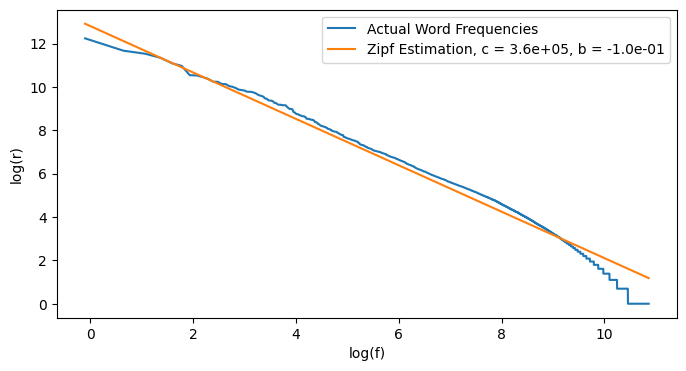

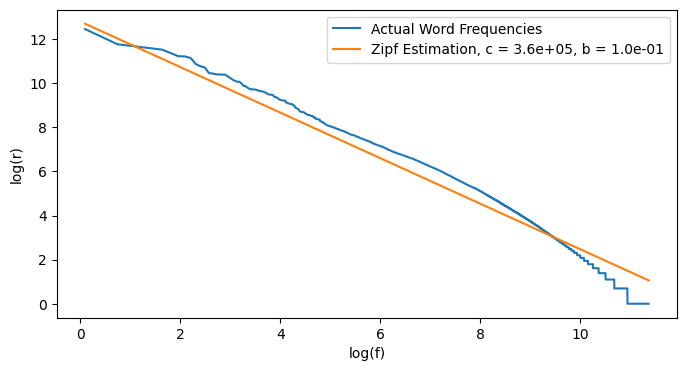

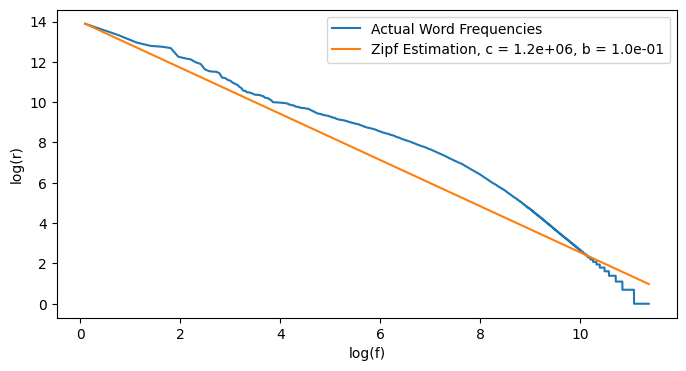

In [260]:
compare_and_plot_zipf('./textStatistics/novels_count.txt', c=np.exp(12.8), b=-0.1)
# plt.savefig('./figures/novels.png', dpi=300)
compare_and_plot_zipf('./textStatistics/news_count.txt', c=np.exp(12.8), b=0.1)
# plt.savefig('./figures/news.png', dpi=300)
compare_and_plot_zipf('./textStatistics/arxiv_count.txt', c=np.exp(14), b=0.1)
# plt.savefig('./figures/arxiv.png', dpi=300)

# Heap's law
Now let's do the same type of analysis with Heap's law - checking if the different texts follow the tendency of diminishing returns.

In [261]:
def get_new_words_count(text_list: List[Tuple[int, str]]) -> Tuple[np.ndarray, np.ndarray]:
    """This function will take in a list of tuples, where every tuple contains a word, and
    the number of times the word has appeared in the text.
    The function should then return two lists:
    1. The first list should just contain integers where the value at index i is (i+1)
    2. The second list should contain, for every index, how many distinct words have appeared up to that index

    Args:
        text_list (List[Tuple[int, str]]): A list of tuples containing word counts and words

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing two lists: the first list should just contain integers where the value at index i is (i+1), and the second list should contain, for every index, how many distinct words have appeared up to that index
    """
    # First let's just extract the number of times each word has popped up
    counts = np.array([count for count, _ in text_list])
    # Now let's make a list where the value at each index corresponds to the
    # number of unique words up until that point
    # I.e. if counts = [1, 2, 5], we get the result [1, 2, 2, 3, 3, 3, 3, 3]
    result = []
    current_distinct_words = 1
    for count in counts:
        result.extend([current_distinct_words] * count)
        current_distinct_words += 1
    assert len(result) == np.sum(counts)
    comparison = np.arange(1, len(result)+1)
    result_arr = np.array(result)
    return result_arr, comparison
    

In [262]:
def heaps_law_extrapolation(k: float, beta: float, N: np.ndarray) -> np.ndarray:
    """Given the word frequencies and ranks, return the predicted word frequencies

    Args:
        k1 (float): Arbitrary constant
        beta (float): Arbitrary constant
        N (np.ndarray): The total number of words in the text

    Returns:
        np.ndarray: The estimated number of distinct words
    """
    return k * np.power(N, beta)

In [263]:
def plot_heap_comparison(
    distinct_words: np.ndarray,
    l1: str,
    estimate: np.ndarray,
    l2: str,
    x: np.ndarray,
    use_log: bool=True) -> None:
    """Plot the number of distinct words and the total number of words, and the estimated line for comparison

    Args:
        distinct_words (np.ndarray): The number of distinct words
        l1 (str): The label for the distinct words
        estimate (np.ndarray): The estimated line estimated by the Heap's law
        l2 (str): The label for the estimated line
        x (np.ndarray): The total number of words
        use_log (bool, optional): Whether to use a log-log plot. Defaults to True.
    """
    x_label = "log(d)"
    y_label = "log(N)"
    if use_log:
        x = np.log(x)
        distinct_words = np.log(distinct_words)
    else:
        x_label = "d"
        y_label = "N"
    plt.figure(figsize=(8, 4))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x, distinct_words, label=l1)
    plt.plot(x, estimate, label=l2)
    plt.legend()

In [272]:
def find_closest_estimate(distinct: np.ndarray, total: np.ndarray, use_log: bool=True) -> np.ndarray:
    """This function will try to tune the hyperparameters k and beta in order
    to get an array that minimizes the RMSE between the distinct-array, and
    the result array

    Args:
        distinct (np.ndarray): The number of distinct words
        total (np.ndarray): The total number of words
        use_log (bool, optional): Whether to use a log-log estimation. Defaults to True.

    Returns:
        np.ndarray: The estimated number of distinct words
    """
    if use_log:
        distinct = np.log(distinct.copy())
        total = np.log(total.copy())
    # First let's just make a list of all possible values for k and beta
    k_values = np.linspace(0, 15, 20)
    beta_values = np.linspace(0.5, 1, 50)
    # Now let's just try every combination of k and beta, and see which one
    # gives the best result
    best_result = None
    best_k = None
    best_beta = None
    best_rmse = np.inf
    count = 1
    print("\nStarting to find best k and beta..")
    for k in k_values:
        for beta in beta_values:
            result = heaps_law_extrapolation(k, beta, total)
            rmse = np.sqrt(np.mean(np.power(result - distinct, 2)))
            if rmse < best_rmse:
                best_rmse = rmse
                best_result = result
                best_k = k
                best_beta = beta
        # Print progress if we've completed 20% of the k-values
        if (count / len(k_values) * 100) % 20 == 0:
            print("Completed {}% of k-values".format(count / len(k_values) * 100))
        count += 1
    print("Best k: {:.10f}, best beta: {:.10f}".format(best_k, best_beta))
    return best_result, best_k, best_beta

In [273]:
def compare_and_plot_heap(
    filepath: str,
    cut_off: float=None,
    use_log: bool=True,
    find_closest: bool=True,
    k: float=None,
    beta: float=None
    ) -> Tuple[np.ndarray, np.ndarray, float, float]:
    text_list = get_clean_text(filepath)
    distinct, total = get_new_words_count(text_list)
    if cut_off is not None:
        distinct = distinct[:np.argmax(total >= cut_off)]
        total = total[:np.argmax(total >= cut_off)]
    if find_closest:
        estimate, k, beta = find_closest_estimate(distinct, total, use_log)
    else:
        if k is None or beta is None:
            raise ValueError("If find_closest is False, you must provide k and beta")
        estimate = heaps_law_extrapolation(k, beta, total)
        if use_log:
            estimate = np.log(estimate)
    plot_heap_comparison(
        distinct,
        "Actual Distinct Words", 
        estimate, 
        "Heap's Law Estimation, k1 = {:.1e}, beta = {:.1e}".format(k, beta), 
        total, use_log=use_log)
    return distinct, estimate, k, beta


Starting to find best k and beta..
Completed 20.0% of k-values
Completed 40.0% of k-values
Completed 60.0% of k-values
Completed 80.0% of k-values
Completed 100.0% of k-values
Best k: 2.3684210526, best beta: 0.6020408163


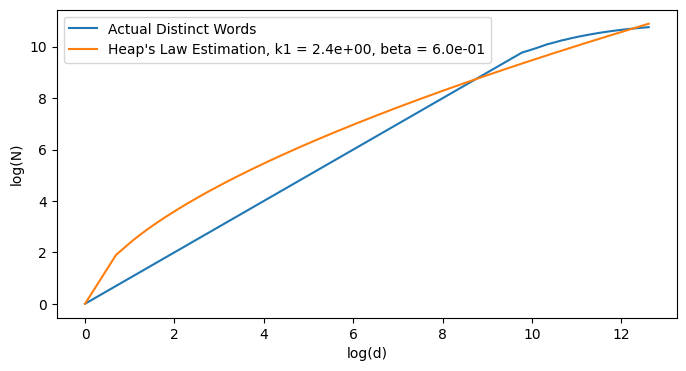

In [266]:
distinct, estimate, k, beta = compare_and_plot_heap('./textStatistics/novels_count.txt', cut_off=0.3e+6, find_closest=True, use_log=True)
# plt.savefig('./figures/novels_full_group.png', dpi=300)


Starting to find best k and beta..
Completed 20.0% of k-values
Completed 40.0% of k-values
Completed 60.0% of k-values
Completed 80.0% of k-values
Completed 100.0% of k-values
Best k: 2.3684210526, best beta: 0.5714285714


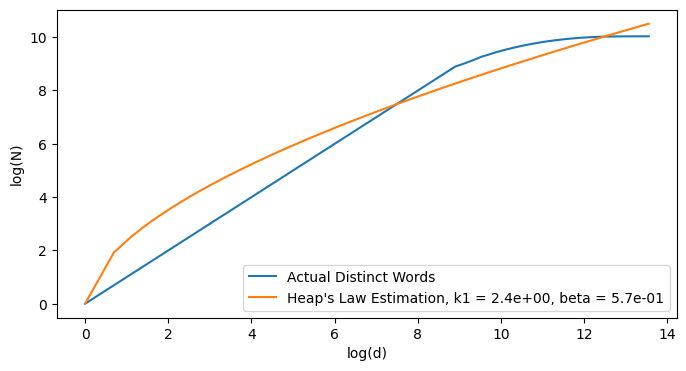

In [267]:
distinct, estimate, k, beta = compare_and_plot_heap('./textStatistics/novel_group_1_count.txt', find_closest=True, use_log=True)
# plt.savefig('./figures/novels_group_1.png', dpi=300)


Starting to find best k and beta..
Completed 20.0% of k-values
Completed 40.0% of k-values
Completed 60.0% of k-values
Completed 80.0% of k-values
Completed 100.0% of k-values
Best k: 2.3684210526, best beta: 0.5714285714


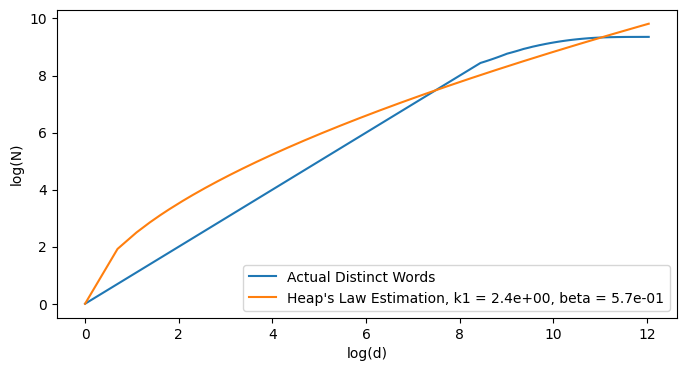

In [268]:
distinct, estimate, k, beta = compare_and_plot_heap('./textStatistics/novel_group_2_count.txt', find_closest=True, use_log=True)
# plt.savefig('./figures/novels_group_2.png', dpi=300)


Starting to find best k and beta..
Completed 20.0% of k-values
Completed 40.0% of k-values
Completed 60.0% of k-values
Completed 80.0% of k-values
Completed 100.0% of k-values
Best k: 2.3684210526, best beta: 0.5816326531


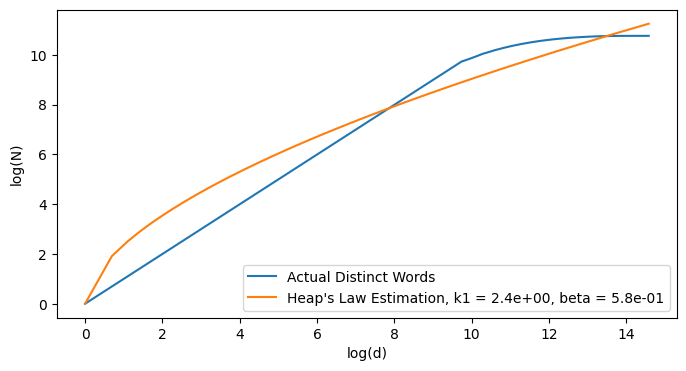

In [279]:
distinct, estimate, k, beta = compare_and_plot_heap('./textStatistics/novel_group_3_count.txt', find_closest=True, use_log=True)
# plt.savefig('./figures/novels_group_3.png', dpi=300)